In [1]:
# Allow access to google drive for working with images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import torch
from torch import nn

print("Torch Version: ", torch.__version__)

# Setup device-agnoistc code
device = "cuda" if torch.cuda.is_available else "cpu"
print("Available Device:", device)

# Setting Random Seed for Reproducibility
RANDOM_SEED = 0

# Set seed for torch
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

Torch Version:  2.1.0+cu118
Available Device: cuda


# Enter Path to Project Folder

In [3]:
PROJECT_DIR = "/content/drive/MyDrive/mole_project/"
sys.path.append(PROJECT_DIR)

# File Paths

In [4]:
from pathlib import Path

# Setup path to data folder
image_path = Path(os.path.join(PROJECT_DIR, "melanoma_cancer_dataset"))

# Setup Train and Testing Paths
train_dir = Path(os.path.join(image_path, "train"))
test_dir = Path(os.path.join(image_path, "test"))

# Visualize the train and test paths
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/mole_project/melanoma_cancer_dataset/train'),
 PosixPath('/content/drive/MyDrive/mole_project/melanoma_cancer_dataset/test'))

# 1) Visualize Example Image

Random image path: /content/drive/MyDrive/mole_project/melanoma_cancer_dataset/train/malignant/melanoma_9266.jpg
Mole Class: malignant
Image Height: 300
Image Width: 300


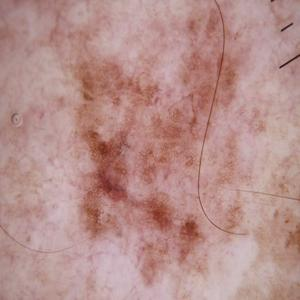

In [5]:
from src.visualizations import visualize_example_img

# Get an example image from the dataset
img = visualize_example_img(image_path)
img

# 2) Image Transformations

In [6]:
from src.transformations import train_transform_tinyvgg, test_transform_tinyvgg

# import the train and test transformations for the images
train_transform = train_transform_tinyvgg
test_transform = test_transform_tinyvgg

print("Train Transformation")
print(train_transform)
print()
print("Test Transformation")
print(test_transform)

Train Transformation
Compose(
    RandomHorizontalFlip(p=0.05)
    RandomApply(
    p=0.05
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
)
    RandomApply(
    p=0.05
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
)
    Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

Test Transformation
Compose(
    Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


# 3) Defining Training, Validation, and, Testing Data

In [7]:
from src.dataloader import load_train_val_test

# Load the train, validation and test datasets
train_data, val_data, test_data = load_train_val_test(train_dir, train_transform, test_dir, test_transform, val_perc=0.1)

# Check the length of the training and testing dataset
print(f"Length of Train: {len(train_data)}")
print(f"Length of Validation: {len(val_data)}")
print(f"Length of Test: {len(test_data)}")
print()
print(f"Dimensions of Image: {train_data[0][0].shape}")

Length of Train: 7745
Length of Validation: 860
Length of Test: 2000

Dimensions of Image: torch.Size([3, 300, 300])


# 4) Load data into data loader

In [8]:
from src.dataloader import load_data_into_dataloader

# Define Batch Size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Load each of the datasets into a data loader
train_dataloader = load_data_into_dataloader(train_data, BATCH_SIZE, NUM_WORKERS)
val_dataloader = load_data_into_dataloader(val_data, BATCH_SIZE, NUM_WORKERS)
test_dataloader = load_data_into_dataloader(test_data, BATCH_SIZE, NUM_WORKERS)

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c2a821d2cb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c2a821d3130>)

# 5) Build Tiny VGG Model

In [9]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # Default stride is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*75*75,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    # Optimized for speed
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

# 6) Train the Tiny VGG Model

In [10]:
from src.training_script import train as Train

NUM_EPOCHS = 10
LEARN_RATE = 0.0001

# Create an instance of the model
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=1).to(device)

# Setup the loss function and the optimizer
# Binary Cross Entropy Loss
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LEARN_RATE)

# Train the model
model_0_results, model_0_state_dict = Train(model=model_0,
                                            train_dataloader=train_dataloader,
                                            val_dataloader=val_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=NUM_EPOCHS,
                                            device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 || Train Loss: 0.54624 || Train Accuracy: 0.71668 || Validation Loss: 0.34571 || Validation Accuracy: 0.85577
Epoch: 2 || Train Loss: 0.34665 || Train Accuracy: 0.85253 || Validation Loss: 0.29257 || Validation Accuracy: 0.87740
Epoch: 3 || Train Loss: 0.31660 || Train Accuracy: 0.86467 || Validation Loss: 0.28715 || Validation Accuracy: 0.89303
Epoch: 4 || Train Loss: 0.30676 || Train Accuracy: 0.86829 || Validation Loss: 0.29060 || Validation Accuracy: 0.89303
Epoch: 5 || Train Loss: 0.30205 || Train Accuracy: 0.87513 || Validation Loss: 0.26674 || Validation Accuracy: 0.89062
Epoch: 6 || Train Loss: 0.29015 || Train Accuracy: 0.87823 || Validation Loss: 0.27151 || Validation Accuracy: 0.90024
Epoch: 7 || Train Loss: 0.28445 || Train Accuracy: 0.88120 || Validation Loss: 0.25982 || Validation Accuracy: 0.90745
Epoch: 8 || Train Loss: 0.27914 || Train Accuracy: 0.88417 || Validation Loss: 0.26232 || Validation Accuracy: 0.89663
Epoch: 9 || Train Loss: 0.27416 || Train Accurac

# 7) Save Trained Model Parameters

In [11]:
# Model Name
MODEL_NAME = f"Tiny_VGG{NUM_EPOCHS}_epochs"

# The directory to store the model
models_dir = os.path.join(PROJECT_DIR, "models")
file_path = os.path.join(models_dir, MODEL_NAME + ".pth")

# Save the model
torch.save(model_0_state_dict, file_path)